1. Descarga y exploración del corpus

Para empezar importo las librerias necesarias para subir el data set elegido y comenzar a trabajar

In [1]:
import gzip
import numpy as np
import pandas as pd
from collections import Counter 
from nltk import ngrams 
from nltk.probability import FreqDist 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from sklearn.decomposition import PCA

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC


In [2]:
# Ruta al archivo en Colab
file_path = "reviews_Beauty_5.json.gz"  #El archivo lo cargué directamente al colab

# Leo el archivo comprimido
with gzip.open(file_path, "rt", encoding="utf-8") as f:
    df = pd.read_json(f, lines=True)


In [3]:
# Muestro las primeras filas y si existen valores nulos 
#Asi veo las columas como:
#reviewText: Texto de la reseña.
#overall: Calificación en estrellas (1-5)
print(df.isnull().sum())
df.head(1)


reviewerID           0
asin                 0
reviewerName      1386
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1,Don't waste your money,1391040000,"01 30, 2014"


In [4]:
#Me quedo sólo con las columnas que me interesan e ignoro los na
df_beauty = df[['reviewText', 'overall']].dropna().copy()

df_beauty.head()



,reviewText,overall
0,Very oily and creamy. Not at all what I expect...,1
1,This palette was a decent price and I was look...,3
2,The texture of this concealer pallet is fantas...,4
3,I really can't tell what exactly this thing is...,2
4,"It was a little smaller than I expected, but t...",3


In [6]:
#Forma 1: para tener una aproximación: sólo convierto a minúsculas y tokenizo por espacios, pero voy a tener el problema de 
#sobretokenización al no sacar signos de puntuación.

splitted_reviews = df_beauty['reviewText'].str.lower().str.split()
words = [word for review in splitted_reviews for word in review]
vocabulary = Counter(words)
print(f"Cardinalidad del vocabulario: {len(vocabulary)}")


Cardinalidad del vocabulario: 331106


Distribución de reviews según sentimiento (número de estrellas)

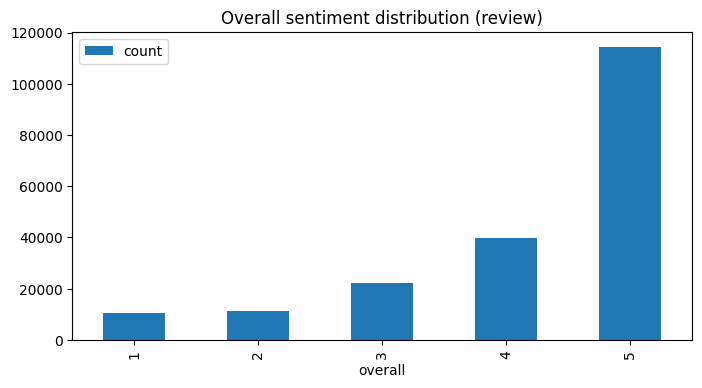

In [7]:
aux_df = pd.DataFrame(df_beauty['overall'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Overall sentiment distribution (review)', figsize=(8, 4))

Nº de reviews positivas y negativas

In [8]:
#Defino 1 para reviews negativas (reviews puntuadas con 3 o menos estrellas) y 0 para reviews positivas(con 4 o más estrellas)
def label_sentiment(row):
    if int(row['overall']) <= 3:
        return 1
    else:
        return 0

In [9]:
#Creo la columna de 'sentiment_label'donde la review se clasifica como positiva(0) o negativa(1)
df_beauty['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)
df_beauty.head()


,reviewText,overall,sentiment_label
0,Very oily and creamy. Not at all what I expect...,1,1
1,This palette was a decent price and I was look...,3,1
2,The texture of this concealer pallet is fantas...,4,0
3,I really can't tell what exactly this thing is...,2,1
4,"It was a little smaller than I expected, but t...",3,1


Positive reviews: 154272
Negative reviews: 44230


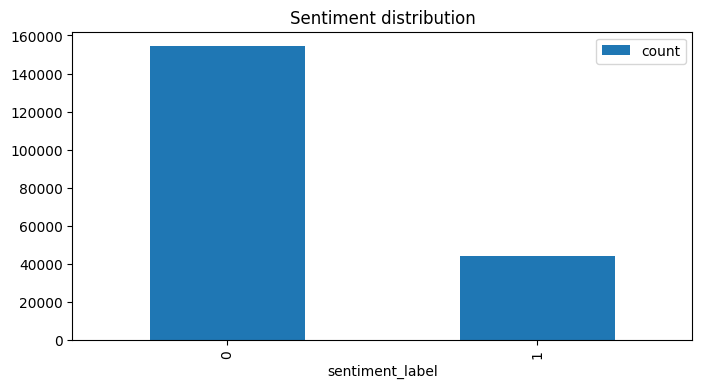

In [10]:
# Cuento reviews positivas (4 o 5 estrellas)
num_positives = df_beauty[df_beauty['overall'] >= 4].shape[0]

# Cuento reviews negativas (1 o 2 o 3 estrellas)
num_negatives = df_beauty[df_beauty['overall'] <= 3].shape[0]

# Muestro resultados analítica y gráficamente
print(f"Positive reviews: {num_positives}")
print(f"Negative reviews: {num_negatives}")

aux_df = pd.DataFrame(df_beauty['sentiment_label'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Sentiment distribution', figsize=(8, 4))


Se puede observar por el histograma tanto de cantida de estrellas como el de distribución de sentimiento que el dataset de reviews está desbalanceado:   77.7% positivas vs. 22.3% negativas

N-grams más frecuentes (sólo miro bigramas y trigramas

In [11]:
bigrams_ = ngrams(words1, 2)
trigrams_ = ngrams(words1, 3)

In [12]:
bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

In [13]:
bigrams_freq_.most_common(10)

[(('i', 'have'), 71557),
 (('my', 'hair'), 57354),
 (('of', 'the'), 45891),
 (('it', 'is'), 45596),
 (('and', 'i'), 42771),
 (('in', 'the'), 41658),
 (('this', 'product'), 38769),
 (('this', 'is'), 38634),
 (('is', 'a'), 37597),
 (('on', 'my'), 33740)]

In [14]:
trigrams_freq_.most_common(10)

[(('this', 'is', 'a'), 11880),
 (('a', 'lot', 'of'), 9755),
 (('i', 'have', 'been'), 7142),
 (('i', 'love', 'this'), 6919),
 (('my', 'hair', 'is'), 6883),
 (('it', 'is', 'a'), 6591),
 (('i', 'use', 'it'), 6294),
 (('i', 'love', 'the'), 6061),
 (('this', 'product', 'is'), 5690),
 (('this', 'is', 'the'), 5584)]

Se ven muchas stopwords . 

Nubes de palabras

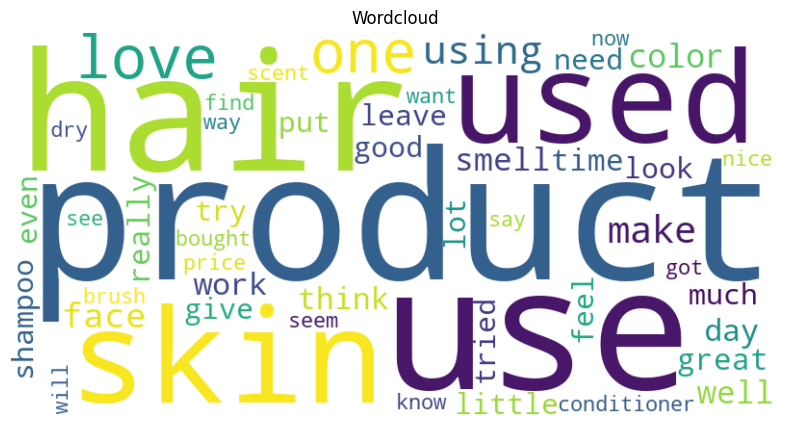

In [17]:
# Uno todos los textos en un solo string
text = " ".join(df_beauty['reviewText'].str.lower())

# Creo la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis", max_words=50).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Ocultar ejes
plt.title("Wordcloud")
plt.show()


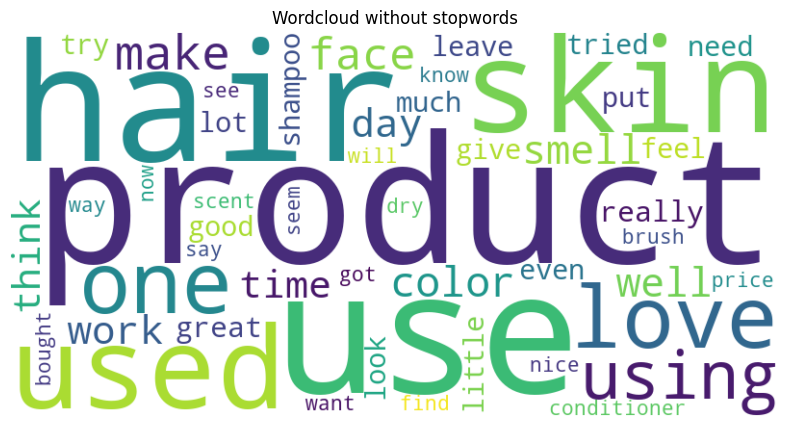

In [90]:
#Pruebo sacando las stopwords, aunque finalmente no se ve una gran diferencia

stopwords = set(STOPWORDS)
wordcloud2 = WordCloud(stopwords=stopwords, width=800, height=400, background_color="white", max_words=50).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")  # Ocultar ejes
plt.title("Wordcloud without stopwords")
plt.show()
 

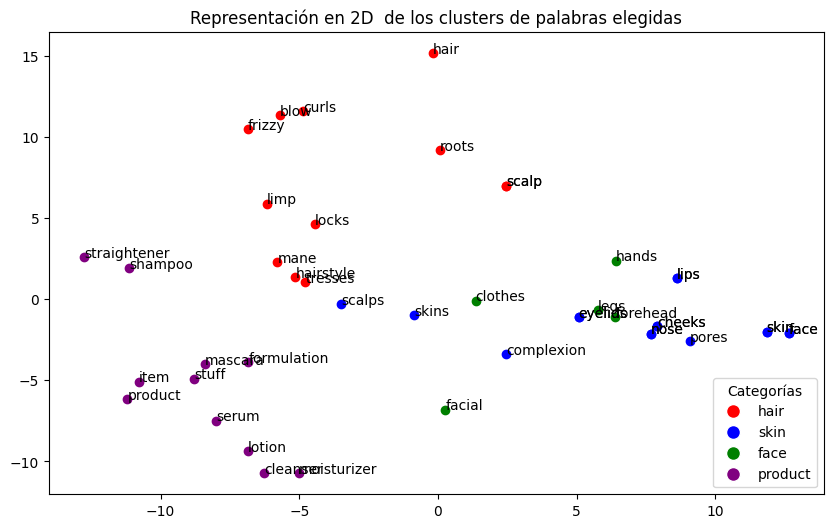

In [24]:
#Visualización en 2 dimensiones de algunos word embeddings calculados con Word2Vec (se eligen 4 palabras y se pintan las top 10 más similares)

# Se tokenizan las reviews para el modelo de Word2Vec y se entrena
sentences = df_beauty["reviewText"].dropna().apply(lambda x: tokenize(x)).tolist()

model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

# Se elijen las siguientes palabras en base al gráfico anterior (wordcloud) y según a mí criterio
# ya que son palabras que pueden ser categorias dentro de "Beauty"
keys = ["hair", "skin", "face", "product"]

# Se obtienen las 10 palabras más similares para cada una
similares = {word: [x[0] for x in model.wv.most_similar(word, topn=10)] for word in keys}

# Se obtienen los vectores de las keys y sus similares
words = sum(similares.values(), []) + keys
word_vectors = model.wv[words]

# Se reducen las dimensiones a 2D con PCA
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

# Se definen los colores para cada grupo, de manera que se distingasn bien
colors = {
    "hair": "red",
    "skin": "blue",
    "face": "green",
    "product": "purple"
}

# Se crea el gráfico
plt.figure(figsize=(10, 6))

for i, word in enumerate(words):
    # Determinar el color según el grupo al que pertenece
    group = next((key for key in keys if word in [key] + similares[key]), "gray")
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1], color=colors.get(group, "gray"))
    plt.annotate(word, (word_vectors_2d[i, 0], word_vectors_2d[i, 1]))

legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[k], markersize=10, label=k) for k in keys]

plt.legend(handles=legend_patches, title="Categorías", loc="lower right")
plt.title("Representación en 2D  de los clusters de palabras elegidas")
plt.show()


En este gráfico podemos ver que los grupos se encuentra suficientemente separados como para identificarse los clusters según las palabras similares a "hair", "skin", "face", "product". Los que se superponen un poco son "face" y "skin", lo cual tiene sentido. Por otro lado palabras que se encuentran en categoría de "product" se encuentran más cercanas según en qué se usan, por ej: "shampoo" también podría pertenecer a la categoría de "hair", de ahí su cercanía en el gráfico. Ídem se pude ver con los productos para la piel ("skin" o "face") como ser "lotion" o "serum".

Basándonos en estos análisis, algunas conclusiones podrían ser:

Cardinalidad del vocabulario: Nos indica cuántas palabras únicas hay, útil para entender la riqueza del lenguaje en las reviews.
Distribución de estrellas: Permite ver si hay un sesgo en la calificación (por ejemplo, si la mayoría de reviews son de 5 estrellas).
Número de reviews positivas vs negativas: Nos ayuda a definir el balance de clases para un modelo de clasificación.
N-grams más frecuentes: Muestra frases comunes en las opiniones, que pueden dar pistas sobre qué características valoran los usuarios.
Nube de palabras: Nos da una idea visual de los términos más usados en las reseñas.
Word2Vec + PCA: Permite visualizar relaciones semánticas entre palabras en un espacio reducido.

2. Etapa de preprocesado de texto

In [20]:
# Se Carga el modelo de lenguaje en inglés
nlp = spacy.load("en_core_web_sm")

def preprocess_text_spacy(text):
    """
    Preprocesamiento de texto usando spaCy.
    Realiza limpieza, tokenización, eliminación de stopwords y lematización.
    """
    # Se procesa el texto con spaCy: convertir a minúsculas y eliminar espacios extra
    doc = nlp(text.lower().strip())  

    # Nos quedamos solo con las palabras (se excluyen puntuación y stopwords) y se lematizan
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    
    return " ".join(tokens)  

df_beauty["processed_review"] = df_beauty["reviewText"].apply(preprocess_text_spacy)


In [21]:
#Se guarda el resultado ya que el procesado tarda varios minutos.
df_beauty.to_pickle("df_beauty_processed")

In [22]:
df_beauty.head()


,reviewText,overall,sentiment_label,processed_review
0,Very oily and creamy. Not at all what I expect...,1,1,oily creamy expect order try highlight contour...
1,This palette was a decent price and I was look...,3,1,palette decent price look different shade pale...
2,The texture of this concealer pallet is fantas...,4,0,texture concealer pallet fantastic great cover...
3,I really can't tell what exactly this thing is...,2,1,tell exactly thing powder kind oil ish pasty f...
4,"It was a little smaller than I expected, but t...",3,1,little small expect okay last long time think ...


In [23]:
#TF-IDF Vectorizer: se buscó obtener la representación del corpus pero no se obtuvo un resultado útil a simple vista

# Creamos el vectorizador
vectorizer = TfidfVectorizer()

# Ajustamos y transformamos los documentos
tf_idf = vectorizer.fit_transform(df_beauty["processed_review"])

# Mostrar términos y valores TF-IDF
df_tfidf = pd.DataFrame(tf_idf.toarray(), columns=vectorizer.get_feature_names_out())
df_tfidf

,aa,aaa,aaaa,aaaaaa,aaaaaaa,aaaaaaaaaahhhhhhhhhhh,aaaaah,aaaaahhhh,aaaaand,aaaagggghhhhh,...,zuz,zuzu,zwillig,zwilling,zy,zyke,zync,zyrtec,zz,zzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


3. Etapa de entrenamiento y testeo de un modelo de análisis de sentimiento

In [25]:
# Se crean los conjuntos de entrenamiento (75%) y de test(25%)
X_train, X_test, y_train, y_test = train_test_split(
    df_beauty["processed_review"],
    df_beauty["sentiment_label"],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [37]:
print("Train instances:", len(X_train))
print("Train labels:", len(y_train))

print("Test instances:", len(X_test))
print("Test labels:", len(y_test))

Train instances: 148876
Train labels: 148876
Test instances: 49626
Test labels: 49626


In [36]:
X_train.iloc[:10]

69176     absolutely love amazing completely say worth m...
129864    super excited pallet hear good thing costal sc...
149445    delighted ingredient doesnot foam leave dark r...
166344    product give user close shave decent lubricati...
59440     skin dry m look nice product dry skin awful sk...
37906     coconut papaya body wash swear well smell body...
184138    recently find bad boy amazon try skin dark spo...
69606     opaque body wash offer moisturization bad lath...
173068    work smooth lotion flatten hair want shampoo t...
177521    hard expect soft tip sure defect suppose use k...
Name: processed_review, dtype: object

In [27]:
y_train.iloc[:10]

69176     0
129864    1
149445    0
166344    1
59440     1
37906     0
184138    0
69606     1
173068    0
177521    1
Name: sentiment_label, dtype: int64

In [42]:
# Se convierte el texto en representación numérica (Bag of Words) con paràmetros donde se limita el vocabulario a las 5000 palabras más frecuentes.

vectorizer = CountVectorizer(max_features = 5000)
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)


In [49]:
#!pip install imbalanced-learn


In [78]:
#Como vimos anteriormente, se trata de un dataset de reviews desbalanceado (77.7% positivas vs. 22.3% negativas), por lo cual enel set
#de training se decidió aplicar un undersampling por la gran cantidad de datos. De esta manera evitamos un sesgo en el modelo de predicción 
#ya que la mayoría de las veces podría predecir a una review como positiva.
#El set de test no se toca ya que debe representar la realidad de los datos.
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_bow, y_train)


/opt/homebrew/anaconda3/envs/nlpbootcamp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/nlpbootcamp/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/nlpbootcamp/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [81]:
# Verificar la distribución después de RandomUnderSampler
print("Distribución después de RandomUnderSampler:", Counter(y_train_resampled))

Distribución después de RandomUnderSampler: Counter({0: 33129, 1: 33129})


In [93]:
#Primer modelo:  regresión logística. Este modelo es adecuado para tareas de clasificación binaria con variables discretas.

lr = LogisticRegression(max_iter=500)
lr.fit(X_train_resampled, y_train_resampled)

# Predicciones y métricas del modelo
y_pred_lr = lr.predict(X_test_bow)

print("Confussion matrix:\n{}".format(confusion_matrix(y_test, y_pred_lr)))
print("\nClassification report:\n{}".format(classification_report(y_test, y_pred_lr)))
print("Accuracy score:{}".format(accuracy_score(y_test, y_pred_lr)))

Confussion matrix:
[[30366  8159]
 [ 2352  8749]]

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.79      0.85     38525
           1       0.52      0.79      0.62     11101

    accuracy                           0.79     49626
   macro avg       0.72      0.79      0.74     49626
weighted avg       0.84      0.79      0.80     49626

Accuracy score:0.7881957038649096


In [94]:
#Primer modelo- sin balancear:  regresión logística. En este caso se probò sin balancear el dataset para ver si realmente mejora el modelo

lr = LogisticRegression(max_iter=500)
lr.fit(X_train_bow, y_train)

# Predicciones y métricas del modelo
y_pred_sinu = lr.predict(X_test_bow)

print("Confussion matrix:\n{}".format(confusion_matrix(y_test, y_pred_sinu)))
print("\nClassification report:\n{}".format(classification_report(y_test, y_pred_sinu)))
print("Accuracy score:{}".format(accuracy_score(y_test, y_pred_sinu)))

Confussion matrix:
[[36409  2116]
 [ 5458  5643]]

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     38525
           1       0.73      0.51      0.60     11101

    accuracy                           0.85     49626
   macro avg       0.80      0.73      0.75     49626
weighted avg       0.84      0.85      0.84     49626

Accuracy score:0.847378390359892



Interpretación de los Resultados con y sin balance del dataset:

Sin Undersampling:

    *)Ventajas:

        Mayor accuracy (85% vs 79%).
        Mejor recall para la clase 0 (95% vs 79%), lo que significa que identifica correctamente la mayoría de las reviews positivas.
        Mayor precisión para la clase 1 (73% vs 52%), lo que indica que las predicciones de reviews negativas son más confiables.

    *)Desventajas:

        Bajo recall para la clase 1 (51% vs 79%), lo que significa que muchas reviews negativas no se identifican correctamente.

Con Undersampling:

    *)Ventajas:

        Mayor recall para la clase 1 (79% vs 51%), lo que significa que identifica mejor las reviews negativas.
        Mayor precisión para la clase 0 (93% vs 87%), lo que indica que las predicciones de reviews positivas son más confiables.

    *)Desventajas:

        Menor accuracy (79% vs 85%).
        Menor recall para la clase 0 (79% vs 95%), lo que significa que muchas reviews positivas no se identifican correctamente.

Conclusión:En este caso y, según según el objetivo planteado, es más importante detectar las reviews negativas, con lo cual el método de undersampling funciona.



In [99]:
#Segundo modelo: Random forest, dado que no se trata de un data set tan grande este modelo funcionaria bien

crf = RandomForestClassifier(
    n_estimators=32,  # Número de árboles en el bosque
    max_depth=None,     # Profundidad máxima de los árboles
    min_samples_split=2,  # Mínimo número de muestras para dividir un nodo
    min_samples_leaf=1,   # Mínimo número de muestras en un nodo hoja
    random_state=42       # Semilla para reproducibilidad
)

# Se enrena el modelo
crf.fit(X_train_resampled, y_train_resampled)

# Predicción
y_pred_cfr = crf.predict(X_test_bow)

# Se evalua el modelo
print("Exactitud (Accuracy):", accuracy_score(y_test, y_pred_cfr))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_cfr))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred_cfr))


Exactitud (Accuracy): 0.7701608028049812
Matriz de confusión:
 [[29965  8560]
 [ 2846  8255]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.91      0.78      0.84     38525
           1       0.49      0.74      0.59     11101

    accuracy                           0.77     49626
   macro avg       0.70      0.76      0.72     49626
weighted avg       0.82      0.77      0.78     49626



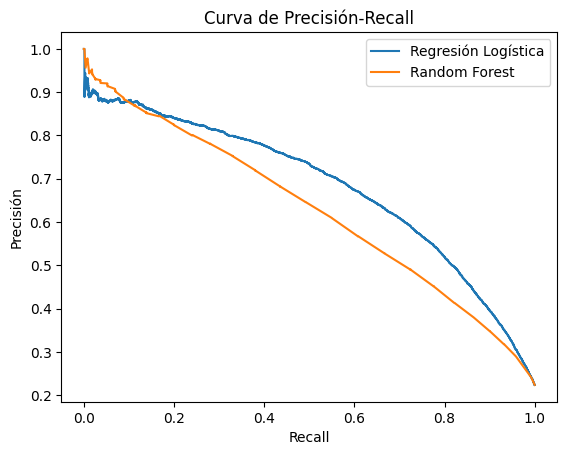

In [91]:
from sklearn.metrics import precision_recall_curve

# Curva de precisión-recall para Regresión Logística
precision_lr, recall_lr, _ = precision_recall_curve(y_test, lr.predict_proba(X_test_bow)[:, 1])

# Curva de precisión-recall para Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, crf.predict_proba(X_test_bow)[:, 1])

# Graficar ambas curvas
plt.plot(recall_lr, precision_lr, label="Regresión Logística")
plt.plot(recall_rf, precision_rf, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precisión")
plt.title("Curva de Precisión-Recall")
plt.legend()
plt.show()

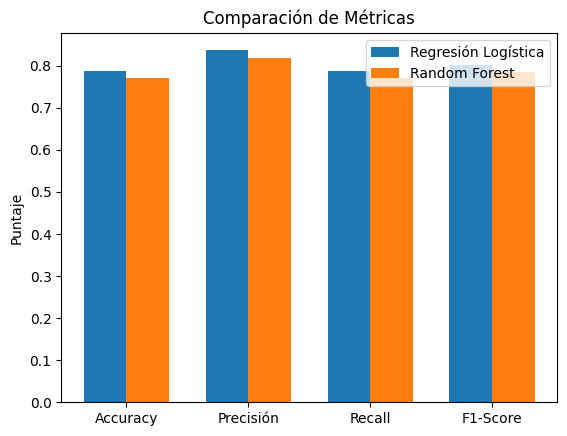

In [100]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Métricas para Regresión Logística
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average="weighted")
recall_lr = recall_score(y_test, y_pred_lr, average="weighted")
f1_lr = f1_score(y_test, y_pred_lr, average="weighted")

# Métricas para Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_cfr)
precision_rf = precision_score(y_test, y_pred_cfr, average="weighted")
recall_rf = recall_score(y_test, y_pred_cfr, average="weighted")
f1_rf = f1_score(y_test, y_pred_cfr, average="weighted")

# Datos para el gráfico
metricas = ["Accuracy", "Precisión", "Recall", "F1-Score"]
lr_scores = [accuracy_lr, precision_lr, recall_lr, f1_lr]
rf_scores = [accuracy_rf, precision_rf, recall_rf, f1_rf]

# Graficar
x = np.arange(len(metricas))
width = 0.35

plt.bar(x - width/2, lr_scores, width, label="Regresión Logística")
plt.bar(x + width/2, rf_scores, width, label="Random Forest")
plt.xticks(x, metricas)
plt.ylabel("Puntaje")
plt.title("Comparación de Métricas")
plt.legend()
plt.show()

Objetivo planteado: identificar correctamente las reviews negativas (clase 1) para tomar acciones correctivas (por ejemplo, mejorar el producto o responder al cliente), entonces el recall de la clase 1 es la métrica más importante. En el último gráfico podemos ver que con el modelo de regresión Logística se obtienen mejor las métricas para el objetivo buscado.

Interpretación de los Resultados de las matrices de confusión:

*Rendimiento en la Clase 0 (Reviews Positivas):
        Ambos modelos tienen un rendimiento similar en la clasificación de reviews positivas, pero la Regresión Logística es ligeramente mejor, ya que tiene más verdaderos positivos (30366 vs 29965) y menos falsos positivos (8159 vs 8560).
        
*Rendimiento en la Clase 1 (Reviews Negativas):
        La Regresión Logística es claramente superior en la clasificación de reviews negativas, ya que tiene más verdaderos negativos (8749 vs 8255) y menos falsos negativos (2352 vs 2846).

*Errores de Clasificación:
        La Regresión Logística comete menos errores tanto en la clasificación de reviews positivas como negativas.

Conclusiones:

La Regresión Logística es mejor para identificar reviews negativas: tiene un mayor número de verdaderos negativos (8749 vs 8255) y menos falsos negativos (2352 vs 2846), lo que significa que es más efectiva para detectar correctamente las reviews negativas.
En cuanto a la Regresión Logística, es más precisa en general, comete menos errores en la clasificación de ambas clases (menos falsos positivos y menos falsos negativos).

